In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.aug_pipelines import medium_aug
from stack_segmentation.io import make_dataloader, collate_fn_basic
from stack_segmentation.training import handle_stacks_data, make_model, train_loop
from stack_segmentation.unet import UNet
from stack_segmentation.pipeline_config import dataloaders_conf, model_conf, train_conf, loss_config

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
model_conf['device'] = 'cuda:1'

In [8]:
data_conf['conf_name'] = 'basic_lr1e-2_epoch300_soft_aug'
data_conf

{'conf_name': 'basic_lr1e-2_epoch300_soft_aug',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slice(None, None, None),
    slice(None, None, N

In [9]:
from stack_segmentation.aug_pipelines import soft_aug
dataloaders_conf['train']['augmentation_pipeline'] = soft_aug(original_height=128, original_width=128)
dataloaders_conf

{'train': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': True,
  'augmentation_pipeline': Compose([
    OneOf([
      RandomSizedCrop(always_apply=False, p=0.5, min_max_height=(32, 128), height=128, width=128, w2h_ratio=1.0, interpolation=1),
      PadIfNeeded(always_apply=False, p=0.5, min_height=128, min_width=128, border_mode=4, value=None, mask_value=None),
    ], p=1),
    VerticalFlip(always_apply=False, p=0.5),
    HorizontalFlip(always_apply=False, p=0.5),
    RandomRotate90(always_apply=False, p=0.5),
    Transpose(always_apply=False, p=0.5),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})},
 'val': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': False,
  'augmentation_pipeline': None},
 'test': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': True,
  'augmentation_pipeline': None}}

In [10]:
train_conf['num_epochs'] = 300
train_conf

{'num_epochs': 300, 'device': 'cuda:1'}

In [11]:
model_conf['opt_type'] = 'SGD'
model_conf['lr'] = 1e-2
model_conf['weight'] = None
model_conf['nesterov'] = True
model_conf

{'device': 'cuda:1',
 'opt_type': 'SGD',
 'lr': 0.01,
 'weight_decay': 0.0001,
 'amsgrad': False,
 'nesterov': True,
 'momentum': 0.9,
 'centered': False,
 'min_lr': 1e-06,
 'factor': 0.5,
 'patience': 5,
 'weight': None}

In [12]:
loss_config =[
    {'loss': 'BCE', 'weight': 1, 'params': {}},
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {}}]

In [13]:
data_conf['patches']

{'train': (128, 128, 1), 'val': (128, 128, 1), 'test': (128, 128, 1)}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 691.66it/s]
100%|██████████| 720/720 [00:07<00:00, 92.13it/s] 
8280it [00:00, 96340.00it/s]
7920it [00:00, 221014.28it/s]
700it [00:00, 830.70it/s]
100%|██████████| 700/700 [00:07<00:00, 99.81it/s] 
8280it [00:00, 251148.66it/s]
7920it [00:00, 239299.85it/s]
710it [00:00, 833.01it/s]
100%|██████████| 710/710 [00:07<00:00, 97.82it/s] 
7920it [00:00, 234676.22it/s]
7560it [00:00, 81555.91it/s]
720it [00:00, 813.42it/s]
100%|██████████| 720/720 [00:07<00:00, 95.85it/s] 
8280it [00:00, 235231.26it/s]
720it [00:03, 228.66it/s]
100%|██████████| 720/720 [00:07<00:00, 95.05it/s] 
25920it [00:00, 136279.76it/s]
700it [00:03, 232.39it/s]
100%|██████████| 700/700 [00:06<00:00, 101.09it/s]
25200it [00:00, 219530.48it/s]
509it [00:01, 333.95it/s]
100%|██████████| 509/509 [00:02<00:00, 193.95it/s]
8144it [00:00, 55135.12it/s]
700it [00:02, 236.23it/s]
100%|██████████| 700/700 [00:06<00:00, 100.96it/s]
25200it [00:00, 232147.36it/s]
700it [00:00, 843.93it/s]
100%|██████████| 700/700 [00

In [15]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [18]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [19]:
device = 'cuda:1'

In [20]:
model, criterion, optimizer, scheduler = make_model(loss_config=loss_config, **model_conf)

## Run experiment

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.057806


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.023914
Epoch 1...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.031673


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.021772
Epoch 2...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.030495


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.021117
Epoch 3...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.030069


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020619
Epoch 4...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029729


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020186
Epoch 5...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029109


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.019936
Epoch 6...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029181


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020036
EarlyStopping counter: 1 out of 10
Epoch 7...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028775


100%|██████████| 732/732 [00:52<00:00, 13.83it/s]


Mean val loss: 0.019194


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 8...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028614


100%|██████████| 732/732 [00:52<00:00, 13.83it/s]


Mean val loss: 0.019142


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 9...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02856


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018312
Epoch 10...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02829


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018231
Epoch 11...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028075


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018197
Epoch 12...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027917


100%|██████████| 732/732 [00:52<00:00, 13.83it/s]


Mean val loss: 0.01819


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 13...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027941


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018673
EarlyStopping counter: 1 out of 10
Epoch 14...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027919


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018086
Epoch 15...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027669


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017781
Epoch 16...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027635


100%|██████████| 732/732 [00:52<00:00, 13.85it/s]


Mean val loss: 0.017516


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 17...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027533


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018466
EarlyStopping counter: 1 out of 10
Epoch 18...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.0274


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017243
Epoch 19...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027422


100%|██████████| 732/732 [00:52<00:00, 13.85it/s]


Mean val loss: 0.017031


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 20...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027436


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017351
EarlyStopping counter: 1 out of 10
Epoch 21...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027173


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017509
EarlyStopping counter: 2 out of 10
Epoch 22...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026996


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016876
Epoch 23...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02709


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016745
Epoch 24...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026941


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016911
EarlyStopping counter: 1 out of 10
Epoch 25...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027046


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016444
Epoch 26...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026752


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016754
EarlyStopping counter: 1 out of 10
Epoch 27...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026777


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017015
EarlyStopping counter: 2 out of 10
Epoch 28...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026498


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016632
EarlyStopping counter: 3 out of 10
Epoch 29...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026576


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017341
EarlyStopping counter: 4 out of 10
Epoch 30...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026616


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016276
Epoch 31...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026357


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01653
EarlyStopping counter: 1 out of 10
Epoch 32...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026431


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016989
EarlyStopping counter: 2 out of 10
Epoch 33...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026383


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015975
Epoch 34...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026294


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016508
EarlyStopping counter: 1 out of 10
Epoch 35...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026192


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016074
EarlyStopping counter: 2 out of 10
Epoch 36...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026373


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016063
EarlyStopping counter: 3 out of 10
Epoch 37...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026206


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015912
Epoch 38...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025937


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016005
EarlyStopping counter: 1 out of 10
Epoch 39...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026228


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01554
Epoch 40...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02612


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01657
EarlyStopping counter: 1 out of 10
Epoch 41...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025803


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016447
EarlyStopping counter: 2 out of 10
Epoch 42...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026051


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016116
EarlyStopping counter: 3 out of 10
Epoch 43...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025933


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015871
EarlyStopping counter: 4 out of 10
Epoch 44...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025832


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015967
EarlyStopping counter: 5 out of 10
Epoch 45...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026056


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015979
EarlyStopping counter: 6 out of 10
Epoch 46...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025855


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015742
EarlyStopping counter: 7 out of 10
Epoch 47...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025758


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015642
EarlyStopping counter: 8 out of 10
Epoch 48...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025611


100%|██████████| 732/732 [00:52<00:00, 13.86it/s]


Mean val loss: 0.015458


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 49...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025663


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015664
EarlyStopping counter: 1 out of 10
Epoch 50...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025656


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016306
EarlyStopping counter: 2 out of 10
Epoch 51...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025638


100%|██████████| 732/732 [00:52<00:00, 13.89it/s]


Mean val loss: 0.015232


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 52...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025648


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015139
Epoch 53...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025608


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015397
EarlyStopping counter: 1 out of 10
Epoch 54...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025762


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015636
EarlyStopping counter: 2 out of 10
Epoch 55...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025609


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015371
EarlyStopping counter: 3 out of 10
Epoch 56...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025311


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015376
EarlyStopping counter: 4 out of 10
Epoch 57...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025493


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01543
EarlyStopping counter: 5 out of 10
Epoch 58...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025357


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015211
EarlyStopping counter: 6 out of 10
Epoch 59...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025421


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015965
EarlyStopping counter: 7 out of 10
Epoch 60...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02536


100%|██████████| 732/732 [00:52<00:00, 13.86it/s]


Mean val loss: 0.015053


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 61...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025413


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015445
EarlyStopping counter: 1 out of 10
Epoch 62...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025294


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015756
EarlyStopping counter: 2 out of 10
Epoch 63...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02528


100%|██████████| 732/732 [00:52<00:00, 13.85it/s]


Mean val loss: 0.014454


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 64...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025159


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015353
EarlyStopping counter: 1 out of 10
Epoch 65...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02508


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014962
EarlyStopping counter: 2 out of 10
Epoch 66...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025269


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015844
EarlyStopping counter: 3 out of 10
Epoch 67...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025267


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015104
EarlyStopping counter: 4 out of 10
Epoch 68...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025256


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01525
EarlyStopping counter: 5 out of 10
Epoch 69...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025237


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015531
EarlyStopping counter: 6 out of 10
Epoch 70...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025092


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014842
EarlyStopping counter: 7 out of 10
Epoch 71...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025126
Epoch    71: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015194
EarlyStopping counter: 8 out of 10
Epoch 72...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.024996


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01497
EarlyStopping counter: 9 out of 10
Epoch 73...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.024763


  0%|          | 0/259 [00:00<?, ?it/s]

Mean val loss: 0.015116
EarlyStopping counter: 10 out of 10


100%|██████████| 788/788 [08:56<00:00,  1.47it/s]


## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [17]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

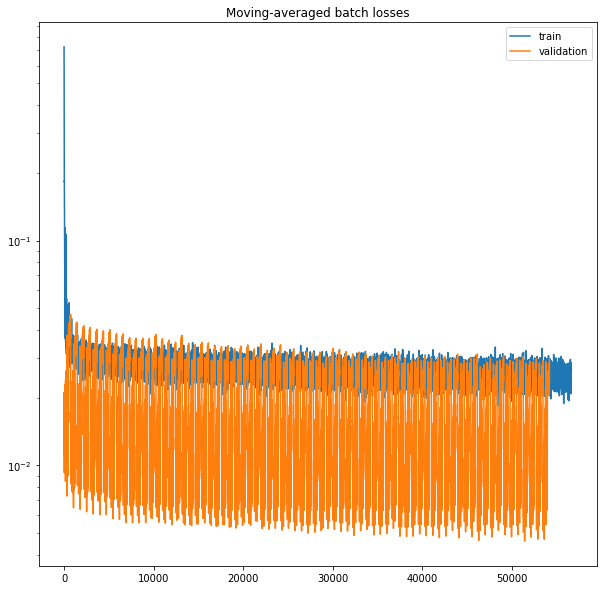

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

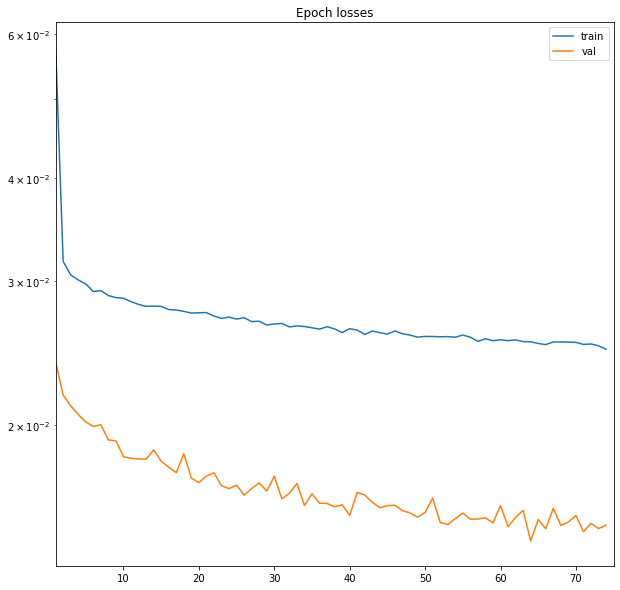

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996526,0.963628,0.981257,0.972363,0.997692,0.946212,carb96558,basic
1,0.988729,0.927528,0.983415,0.954654,0.994148,0.913242,carb71,basic
2,0.973522,0.995072,0.800217,0.887070,0.990500,0.797059,carbRNF,basic
3,0.991405,0.997650,0.900433,0.946552,0.996365,0.898527,SPE_carb10_58_box3,basic
4,0.988422,0.985783,0.899213,0.940510,0.991972,0.887701,SoilAh-1,basic
5,0.996189,0.975971,0.969065,0.972506,0.997612,0.946483,SoilB-2,basic
6,0.989731,0.996847,0.922228,0.958087,0.997656,0.919546,TeTree_subset1,basic
7,0.992294,0.997144,0.937591,0.966451,0.998465,0.935080,TiTree_subset2,basic
8,0.992144,0.971340,0.966567,0.968948,0.996991,0.939766,Urna_22,basic
9,0.990339,0.979571,0.965383,0.972425,0.997905,0.946330,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.91246
Std    IOU: 0.04348
Min    IOU: 0.79706
Median IOU: 0.91955
